# Practice 1: Evasion against Image classifier 
- Task 1: Untargeted attack against an image
- Task 2: Targeted attack against an image

In [2]:
from PIL import Image
from torchvision import transforms
from IPython.display import display
import matplotlib.pyplot as plt

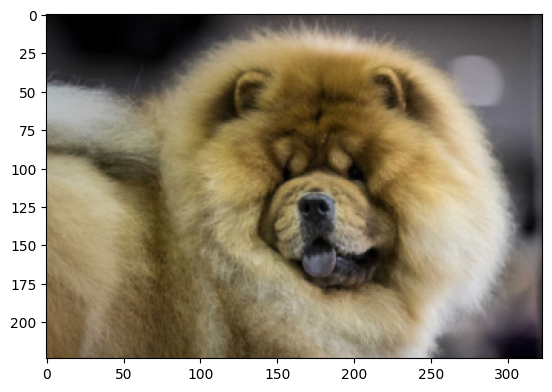

In [3]:
# read the image, resize to 224 and convert to PyTorch Tensor
img = Image.open("dog.jpg")

preprocess = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
    ]
)
dog_tensor = preprocess(img)[None, :, :, :]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(dog_tensor[0].numpy().transpose(1, 2, 0))

# Load torchvision models

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Create normalization module
the weird indexing here is just used to comply with PyTorch standards that all inputs to modules should be of the form batch_size x num_channels x height x width).

In [5]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[
            None, :, None, None
        ]


# values are standard normalization for ImageNet images,
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Load pre-trained ResNet50

In [6]:
# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval()

/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlatok/Evasion1-white_box/.env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlatok/Evasion1-white_box/.env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/melidon/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Predict our test sample

In [7]:
# predict the loaded image
pred = model(norm(dog_tensor))
print(pred.shape)
# print probabilities

# load json file
import json

with open("imagenet_class_index.json") as f:
    id2obj = {int(k): v[1] for k, v in json.load(f).items()}
# invert the dictionary
obj2id = {v: k for k, v in id2obj.items()}

print(id2obj)
print(obj2id)

# get the index of the maximum value
pred_idx = torch.argmax(pred).item()
print("Predicted class:", id2obj[pred_idx])
# print confidence of prediction
print("Confidence:", torch.nn.Softmax()(pred[0])[pred_idx].item())

# print(pred.shape)
# print(torch.nn.Softmax()(pred[0]))

torch.Size([1, 1000])
{0: 'tench', 1: 'goldfish', 2: 'great_white_shark', 3: 'tiger_shark', 4: 'hammerhead', 5: 'electric_ray', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich', 10: 'brambling', 11: 'goldfinch', 12: 'house_finch', 13: 'junco', 14: 'indigo_bunting', 15: 'robin', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water_ouzel', 21: 'kite', 22: 'bald_eagle', 23: 'vulture', 24: 'great_grey_owl', 25: 'European_fire_salamander', 26: 'common_newt', 27: 'eft', 28: 'spotted_salamander', 29: 'axolotl', 30: 'bullfrog', 31: 'tree_frog', 32: 'tailed_frog', 33: 'loggerhead', 34: 'leatherback_turtle', 35: 'mud_turtle', 36: 'terrapin', 37: 'box_turtle', 38: 'banded_gecko', 39: 'common_iguana', 40: 'American_chameleon', 41: 'whiptail', 42: 'agama', 43: 'frilled_lizard', 44: 'alligator_lizard', 45: 'Gila_monster', 46: 'green_lizard', 47: 'African_chameleon', 48: 'Komodo_dragon', 49: 'African_crocodile', 50: 'American_alligator', 51: 'triceratops', 52: 'thunder_snake', 53: 'ring

/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlatok/Evasion1-white_box/.env/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# Read mapping from index to class name

## Get the label, and print the loss and the predicted label

# PGD attack (white-box)

In [8]:
import torch.optim as optim

## Task 1: Untargeted (maximize the loss)

0 -0.06442513316869736


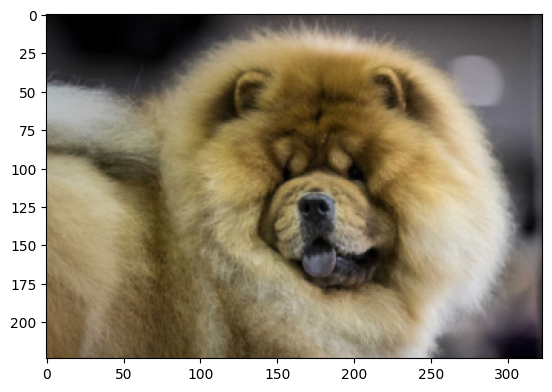

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 -14.895393371582031


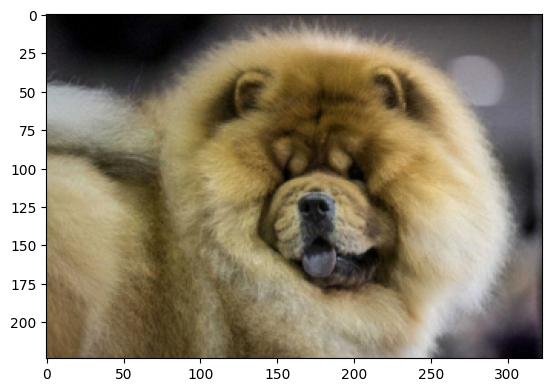

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10 -12.457598686218262


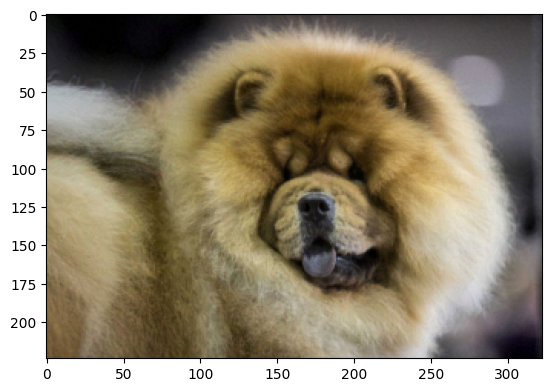

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15 -23.26602554321289


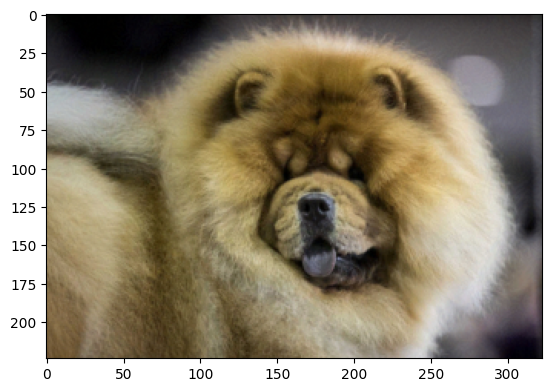

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20 -24.17254066467285


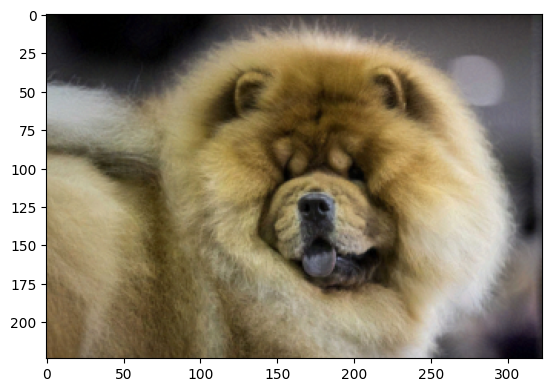

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25 -27.900691986083984


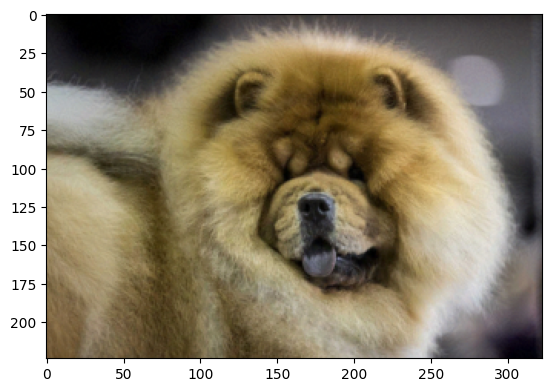

In [10]:
# create a random image (gray) with the same size as the dog image
delta = torch.zeros_like(dog_tensor, requires_grad=True)

# maximum perturbation
eps = 2 / 255.0

# create opt (SGD)
opt = optim.SGD([delta], lr=1)

# SGD iterations (30)
for t in range(30):
    # forward pass (predict with noise image, and normalize the image with mean and std of ImageNet)
    pred = model(norm(dog_tensor + delta))

    # maximize the loss of target class (give long tensor as target class), we have to take the negative sign
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([pred_idx]))

    # print loss and show image every 5 iterations
    if t % 5 == 0:
        print(t, loss.item())
        # plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))
        # plt.show()

    # zero all existing gradients
    opt.zero_grad()

    # backward pass
    loss.backward()

    # take the sign of the gradient
    delta.grad.sign_()
    delta.grad.data *= 0.01

    # update the noise
    opt.step()

    # projection with clipping
    delta.data.clamp_(-eps, eps)

In [11]:
# Check new prediction and confidence scores
pred = model(norm(dog_tensor + delta))
pred_idx_adv = torch.argmax(pred).item()
print("Predicted class:", id2obj[pred_idx_adv])
# print confidence of prediction
print("Confidence:", torch.nn.Softmax()(pred[0])[pred_idx_adv].item())
# print confidence of original prediction
print("Confidence original:", torch.nn.Softmax()(pred[0])[pred_idx].item())

Predicted class: langur
Confidence: 0.9887366890907288
Confidence original: 1.1345880466251401e-06


/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlatok/Evasion1-white_box/.env/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


# Show original image and perturbed image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


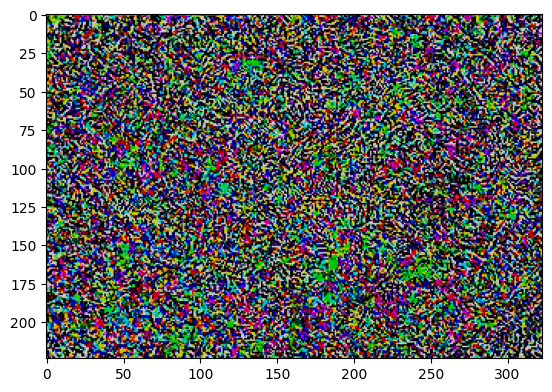

In [13]:
# Let's see the result

# original image (detach the tensor and convert to numpy then transpose CHW to HWC)
plt.imshow(dog_tensor[0].detach().numpy().transpose(1, 2, 0))

# noisy image (detach the tensor and convert to numpy then transpose CHW to HWC)
plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))

# display noise
plt.imshow((delta*100)[0].detach().numpy().transpose(1, 2, 0))

# display images
plt.show()

# Targeted attack (do to a toaster)

In [14]:
# get class number of toaster
target_idx = obj2id["toaster"]
print(target_idx)

859


In [16]:
# misclassify as toaster

# create a random image (gray) with the same size as the dog image
delta = torch.zeros_like(dog_tensor, requires_grad=True)

# maximum perturbation
eps = 2 / 255.0

# create opt (SGD)
opt = optim.SGD([delta], lr=1)

# SGD iterations (30)
for t in range(30):
    # forward pass (predict with noise image, and normalize the image with mean and std of ImageNet)
    pred = model(norm(dog_tensor + delta))

    # maximize the loss of target class (give long tensor as target class), we have to take the negative sign
    loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([target_idx])) # - nn.CrossEntropyLoss()(pred, torch.LongTensor([pred_idx]))

    # print loss and show image every 5 iterations
    if t % 5 == 0:
        print(t, loss.item())
        # plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))
        # plt.show()

    # zero all existing gradients
    opt.zero_grad()

    # backward pass
    loss.backward()

    # take the sign of the gradient
    delta.grad.sign_()
    delta.grad.data *= 0.01

    # update the noise
    opt.step()

    # projection with clipping
    delta.data.clamp_(-eps, eps)

0 12.079411506652832
5 0.05228523910045624
10 0.03160788491368294
15 0.006075248587876558
20 0.0012134101707488298
25 0.00021610308613162488


In [17]:
# print prediction and confidence
pred = model(norm(dog_tensor + delta))
pred_idx_adv = torch.argmax(pred).item()
print("Predicted class:", id2obj[pred_idx_adv])
# print confidence of prediction
print("Confidence:", torch.nn.Softmax()(pred[0])[pred_idx_adv].item())
# print confidence of original prediction
print("Confidence original:", torch.nn.Softmax()(pred[0])[pred_idx].item())

Predicted class: toaster
Confidence: 0.5265614986419678
Confidence original: 0.4128931164741516


/home/melidon/Egyetem/msc/3_felev/a_gepi_tanulas_biztonsaga/gyakorlatok/Evasion1-white_box/.env/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


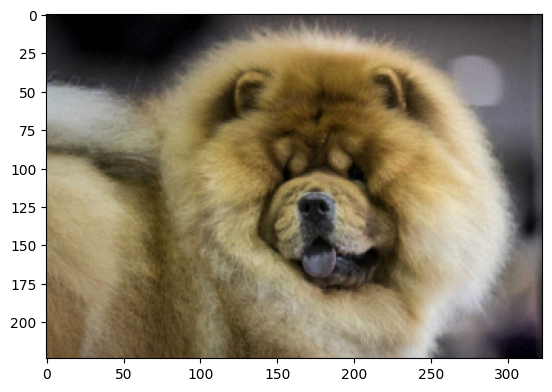

In [18]:
# show noisy image
plt.imshow((dog_tensor + delta)[0].detach().numpy().transpose(1, 2, 0))
plt.show()

## How the noise looks like?

In [ ]:
# display noise (scale the noise to be visible)